In [8]:
%load_ext autoreload
%autoreload 2

In [13]:
import sys
print(sys.version)

3.7.9 (default, Oct 18 2020, 22:55:02) 
[Clang 10.0.1 (clang-1001.0.46.4)]


In [92]:
import os
import pickle
import random

import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import trange, tqdm
from IPython.display import display, Audio

In [20]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Device: {device}")

Device: cuda


In [12]:
torch.manual_seed(0);

## Loading the dataset

In [72]:
DATA_ROOT = "data/pop_pickle"
N_SAMPLES = 909
VOCAB_SIZE = 389
BOS_TOKEN = VOCAB_SIZE

In [73]:
dataset = []
for i in range(N_SAMPLES):
    file_name = str(i + 1).zfill(3) + ".pickle"
    path = os.path.join(DATA_ROOT, file_name)
    with open(path, "rb") as f:
        seq = pickle.load(f)
        seq.insert(BOS_TOKEN, 0)
        seq_tensor = torch.LongTensor(seq)
    dataset.append(seq_tensor)

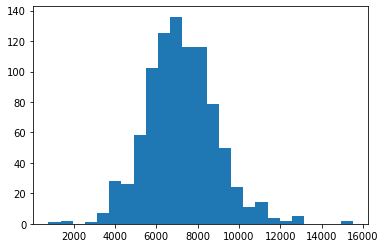

In [74]:
seq_lens = [len(seq) for seq in dataset]

plt.figure()
plt.hist(seq_lens, bins=25)
plt.show()

In [75]:
N_VAL = N_TEST = int(0.05 * 909)
N_TRAIN = 909 - (N_VAL + N_TEST)

train_data = dataset[:N_TRAIN]
val_data = dataset[N_TRAIN:N_TRAIN+N_VAL]
test_data = dataset[N_TRAIN+N_VAL:]

print(f"Train: {len(train_data)} \t Val: {len(val_data)} \t Test: {len(test_data)}")

Train: 819 	 Val: 45 	 Test: 45


## Training the initial model

In [101]:
class MusicRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, rnn_type="lstm", num_layers=1):
        assert rnn_type in ["lstm", "gru"]

        super().__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.rnn_type = rnn_type
        self.num_layers = num_layers

        self.embeddings = nn.Embedding(input_size, hidden_size)
        self.rnn = (
            nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True) if rnn_type == "lstm"
            else nn.GRU(hidden_size, hidden_size, num_layers, batch_first=True)
        )
        self.fc = nn.Linear(self.hidden_size, self.output_size)
    
        self.hidden_state = None

    def forward(self, x, reset_hidden_state=True):
        x = self.embeddings(x)

        # Add fake batch dimension.
        x = x.unsqueeze(0)

        # Forward pass through RNN and FC layer.
        if reset_hidden_state:
            x, _ = self.rnn(x)
        else:
            x, self.hidden_state = self.rnn(x, self.hidden_state)
        
        # Map to output space.
        x = self.fc(x)
        
        # Remove fake batch dimension.
        x = x.squeeze(0)

        return x

In [102]:
CHECKPOINT_PATH = "models/checkpoint.pt"

HIDDEN_SIZE = 64
NUM_EPOCHS = 50
LEARNING_RATE = 1e-3

LOG_EVERY_N = 1
SAVE_EVERY_N = 1

In [98]:
model = MusicRNN(
    input_size=VOCAB_SIZE,
    hidden_size=HIDDEN_SIZE,
    output_size=VOCAB_SIZE,
    rnn_type="lstm",
    num_layers=1,
).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [99]:
print(model)

MusicGenerator(
  (embeddings): Embedding(389, 64)
  (rnn): LSTM(64, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=389, bias=True)
)


In [ ]:
for epoch in range(1, NUM_EPOCHS + 1):
    random.shuffle(train_data)
    total_loss = 0.0
    for seq in tqdm(train_data):
        seq = seq.to(device)

        # Reset gradients.
        model.zero_grad()
        
        # Prepare inputs and targets.
        x = seq[:-1]
        y = seq[1:]
                
        # Forward prop.
        y_hat = model(x)
        
        # Compute loss.
        loss = loss_function(y_hat, y)
        total_loss += loss.item()

        # Back prop.
        loss.backward()
        
        # Update parameters.
        optimizer.step()
        
    if epoch % LOG_EVERY_N == 0:
        avg_loss = total_loss / N_TRAIN
        print(f"Epoch: {epoch} \t Avg loss: {avg_loss}")
    
    if epoch % SAVE_EVERY_N == 0:
        torch.save(
            {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
            },
            CHECKPOINT_PATH,
        )